# Customer Clustering and Segmentation

## Setup and Initialization

### Importing necessary Libraries

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set_theme(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

### Loading the dataset

In [4]:
customer_data = pd.read_csv('../datasets/customer_data.csv')

In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      187 non-null    object 
 1   Days_Since_Last_Purchase        187 non-null    int64  
 2   Total_Transactions              187 non-null    int64  
 3   Total_Products_Purchased        187 non-null    int64  
 4   Total_Spend                     187 non-null    float64
 5   Average_Transaction_Value       187 non-null    float64
 6   Unique_Products_Purchased       187 non-null    int64  
 7   Average_Days_Between_Purchases  187 non-null    float64
 8   Day_Of_Week                     187 non-null    int64  
 9   Hour                            187 non-null    int64  
 10  Hemisphere_East                 187 non-null    int64  
 11  Hemisphere_West                 187 non-null    int64  
 12  Monthly_Spending_Mean           187 

## Outlier Detection and Treatment

In [6]:
# initializin the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

In [7]:
# fitting the model on our dataset
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:,1:])

In [8]:
# create a new column to identify outliers (-1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

In [9]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Hemisphere_East,Hemisphere_West,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,C0001,56,5,12,3354.52,670.904,5,72.000000,1,3,0,1,670.904000,456.643861,217.032000,1,0
1,C0002,25,4,10,1862.74,465.685,4,48.000000,1,1,1,0,465.685000,219.519169,-147.630000,1,0
2,C0003,126,4,14,2725.38,681.345,4,27.333333,6,2,0,1,908.460000,685.907372,631.420000,1,0
3,C0004,5,8,23,5354.88,669.360,8,22.428571,0,10,0,1,764.982857,489.591411,70.506429,1,0
4,C0005,54,3,7,2034.24,678.080,3,91.500000,0,0,1,0,678.080000,310.820746,-270.990000,1,0


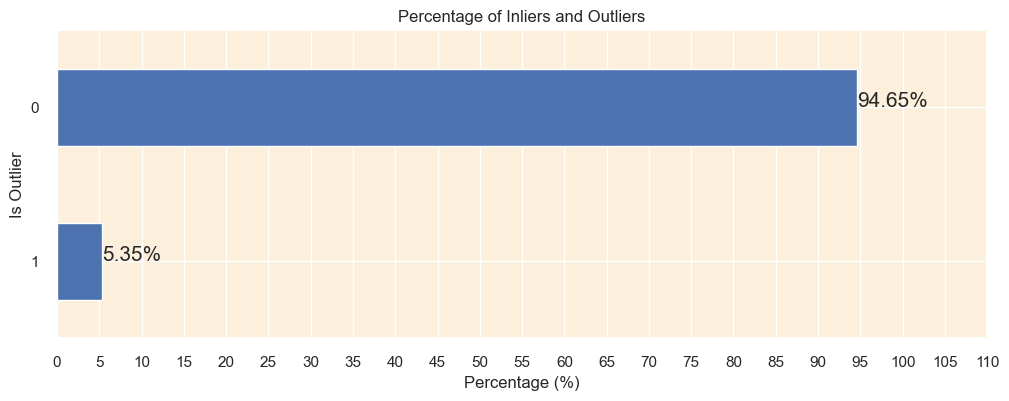

In [10]:


# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

Inference:
- From the above plot, we can observe that about 5.35% of the customers have been identified as outliers in our dataset.

In [11]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [12]:
customer_data_cleaned.shape[0]

177

We have successfully separated the outliers for further analysis and cleaned our main dataset by removing these outliers. This cleaned dataset is now ready for the next steps in our customer segmentation

## Correlation Analysis

Before we start KMeans clustering, we need to examine the correlation between the features in our dataset.  The presence of multicollinearity, when features are highly linked, can potentially impair the clustering process by not allowing the model to learn the true underlying patterns in the data, as the features do not provide unique information.  This could lead to clusters that are not well-separated and meaningful.

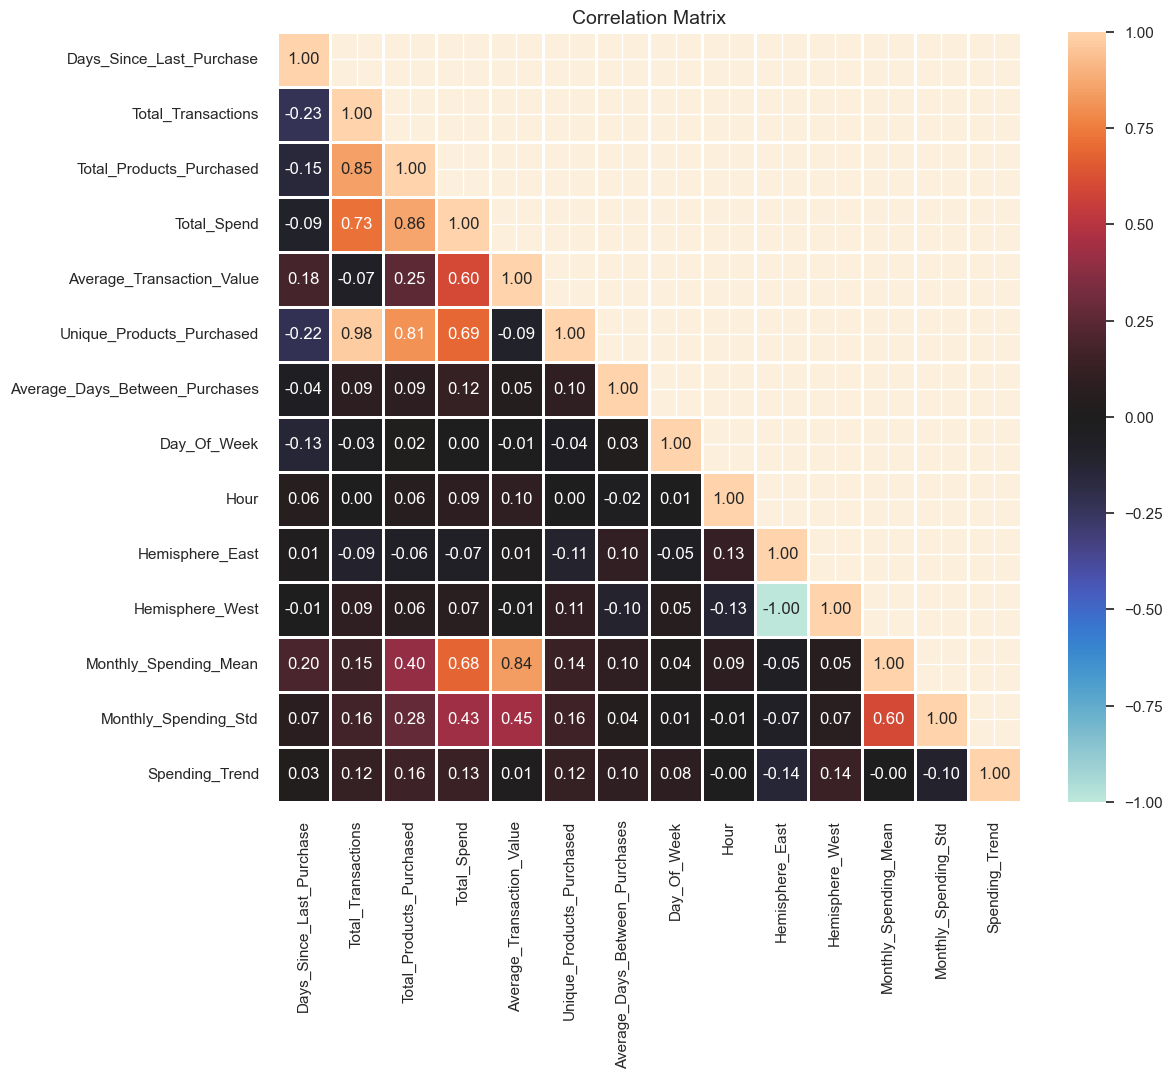

In [13]:
# calculate the correlation matrix exclusing the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Inference:
Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:
- `Total_Products_Purchased` and `Total_Transactions`

- `Total_Spend` and `Total_Transactions`

- `Total_Spend` and `Total_Products_Purchased`

- `Unique_Products_Purchased` and `Total_Transactions`

- `Unique_Products_Purchased` and `Total_Products_Purchased`

- `Unique_Products_Purchased` and `Total_Spend`

- `Monthly_Spending_Mean` and `Total_Spend`

- `Monthly_Spending_Mean` and `Average_Transaction_Value`

Before proceeding to the next steps, considering the influence of multicollinearity on KMeans clustering, it may be helpful to handle this multicollinearity, maybe using dimensionality reduction techniques such as PCA, to construct a collection of uncorrelated variables.  This will aid in obtaining more stable clusters throughout the KMeans clustering process.

## Feature Scaling

Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA.

In [14]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Hemisphere_East', 'Hemisphere_West', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Hemisphere_East,Hemisphere_West,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,C0001,-0.141367,-0.165493,-0.267263,-0.179541,-0.095299,-0.098327,1.686431,1,-0.605561,0,1,-0.581605,-0.467878,0.593056
1,C0002,-0.747369,-0.707943,-0.644200,-1.109178,-1.037193,-0.659743,1.165860,1,-0.935867,1,0,-1.250742,-1.377619,-0.322379
2,C0003,1.227023,-0.707943,0.109674,-0.571604,-0.047378,-0.659743,0.717590,6,-0.770714,0,1,0.192970,0.411704,1.633321
3,C0004,-1.138337,1.461857,1.805889,1.067029,-0.102385,1.585920,0.611203,0,0.550510,0,1,-0.274852,-0.341473,0.225223
4,C0005,-0.180464,-1.250393,-1.209605,-1.002303,-0.062363,-1.221158,2.109395,0,-1.101020,1,0,-0.558207,-1.027336,-0.632058


## Dimenstionality Reduction

Why do we need Dimensionality Reduction?
- `Multicollinearity Detected`
- `Noise Reduction`
- `Better clustering with K-Means`
- `Improved Computational Efficiency`

I will apply PCA on all the available components and plot the cumulative variance explained by them.

In [15]:
# setting CustomerID as the index
customer_data_scaled.set_index('CustomerID', inplace=True)

In [16]:
# apply PCA
pca = PCA().fit(customer_data_scaled)

In [17]:
# calculate cumulative sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

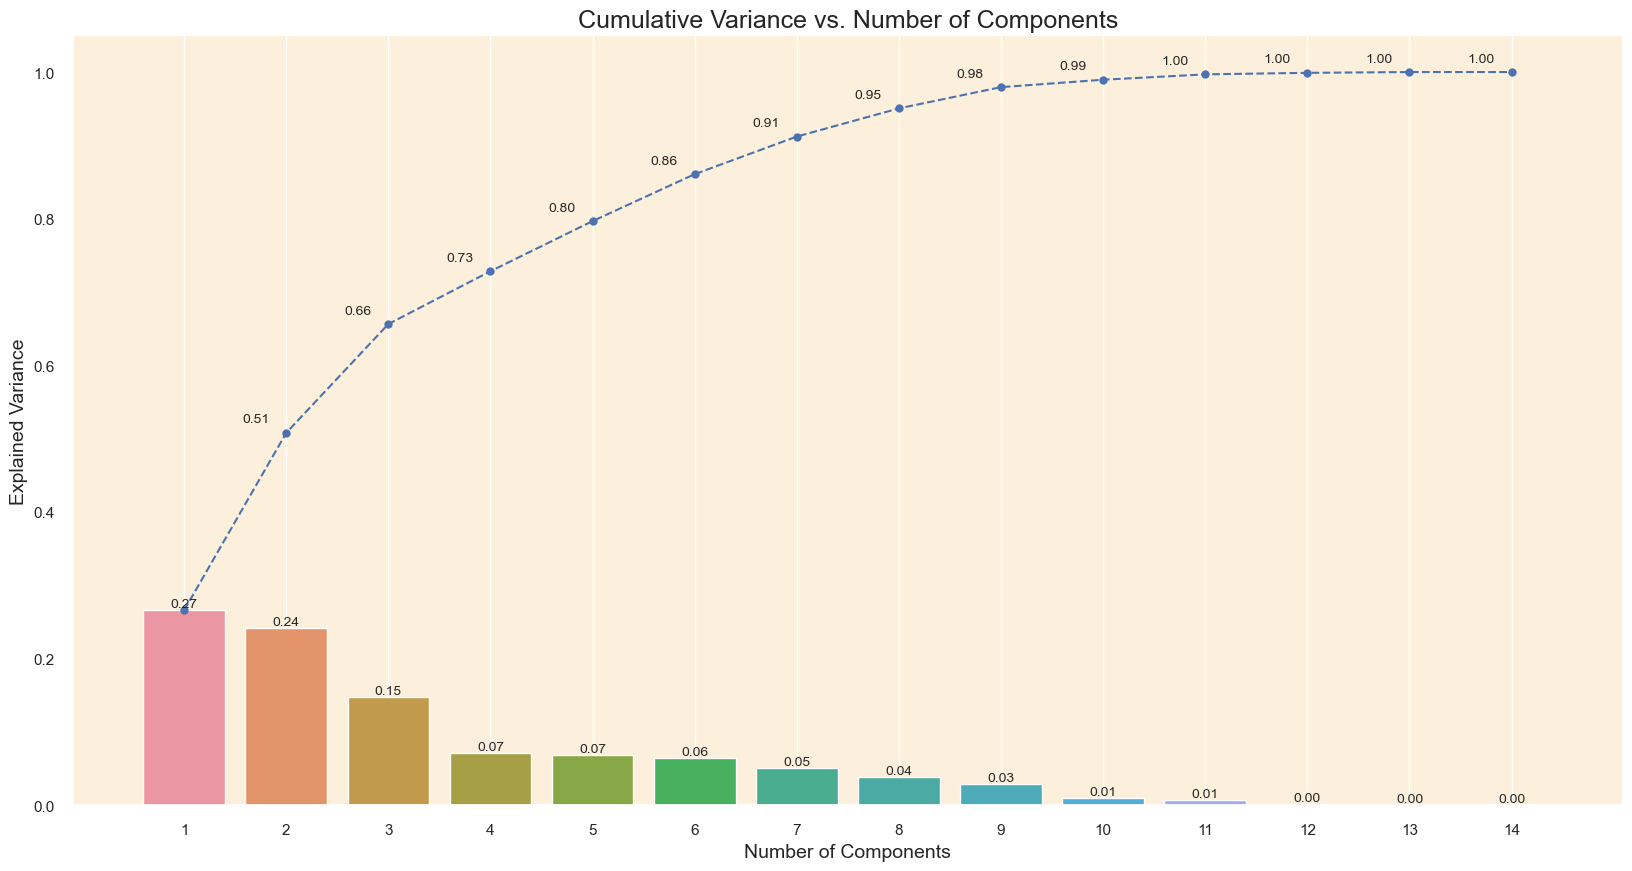

In [18]:
# plot the cumulative explained variance against the number of components
plt.figure(figsize=(20,10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance)+1)),
                      y=explained_variance_ratio)

lineplot = plt.plot(range(0, len(cumulative_explained_variance)),
                    cumulative_explained_variance,
                    marker='o', linestyle='--')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)


# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

Inference:
Here, we observe that:
- The frst component explains approximately 27% of the variance
- The first two components together explain about 51% of the variance
- The first three components explain approximately 66% of the variance, and so on.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 80% of the total variance).

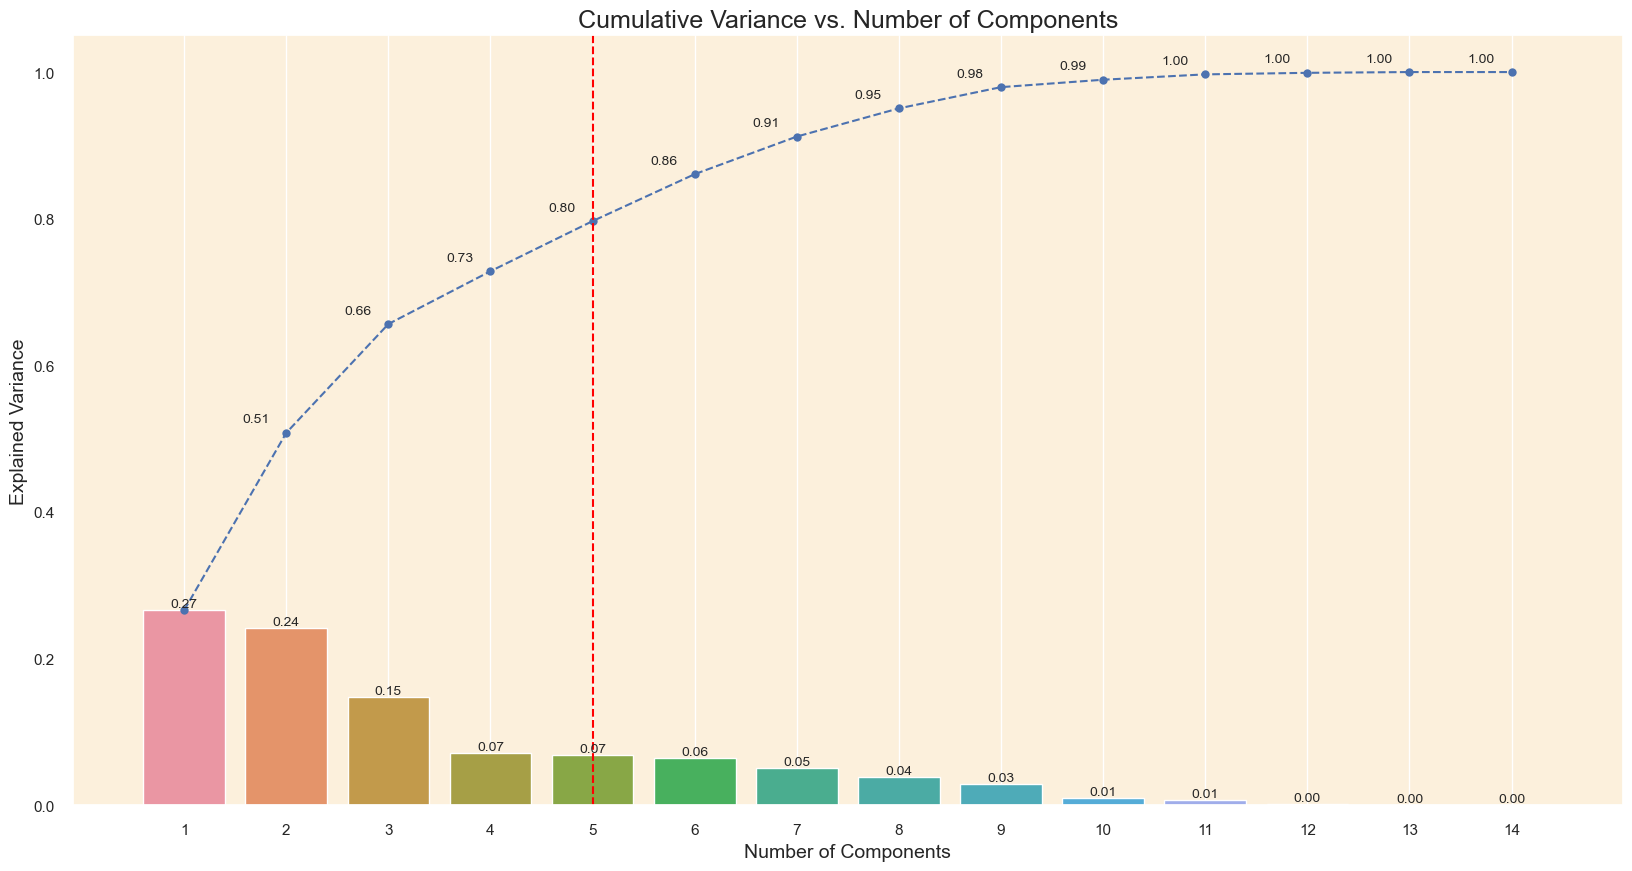

In [19]:
# plot the cumulative explained variance against the number of components
plt.figure(figsize=(20,10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance)+1)),
                      y=explained_variance_ratio)

lineplot = plt.plot(range(0, len(cumulative_explained_variance)),
                    cumulative_explained_variance,
                    marker='o', linestyle='--')

#set optimal k based on our analysis (6)
optimal_k = 5

optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--')


plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

Retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [20]:
# creating a pca object with 5 components
pca = PCA(n_components=5)

customer_data_pca = pca.fit_transform(customer_data_scaled)

# create a new dataframe from PCA dataframe
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# adding CustomerID to new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [21]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5
CustomerID,,,,,
C0001,-0.525982,-1.135935,-0.555989,1.300411,-1.256674
C0002,-2.389949,-1.058234,-1.328285,0.332534,-1.157549
C0003,-0.311553,3.779544,0.824877,1.712971,-0.907364
C0004,2.396056,-2.301749,-2.013801,0.221482,0.290412
C0005,-2.531046,-2.065708,0.278665,0.735557,-1.820879


## K-Means Clustering

K-Means:

- K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

### Finding the optimal number of Clusters

To identify the optimal number of clusters (k) for segmenting customers, I will explore three methods:
- Elbow Method
- Silhouette Method
- Davies-Bouldin Index

#### Elbow Method
The elbow method is a heuristic used to determine the optimal number of clusters in a data set. It's a graphical method that plots the within-cluster-sum-of-square (WCSS) values against the number of clusters. The point where the graph forms an elbow indicates the optimal number of clusters.

In [22]:
# Instantiate the clustering model
km = KMeans(init='k-means++', n_init=10, max_iter=300, random_state=0)

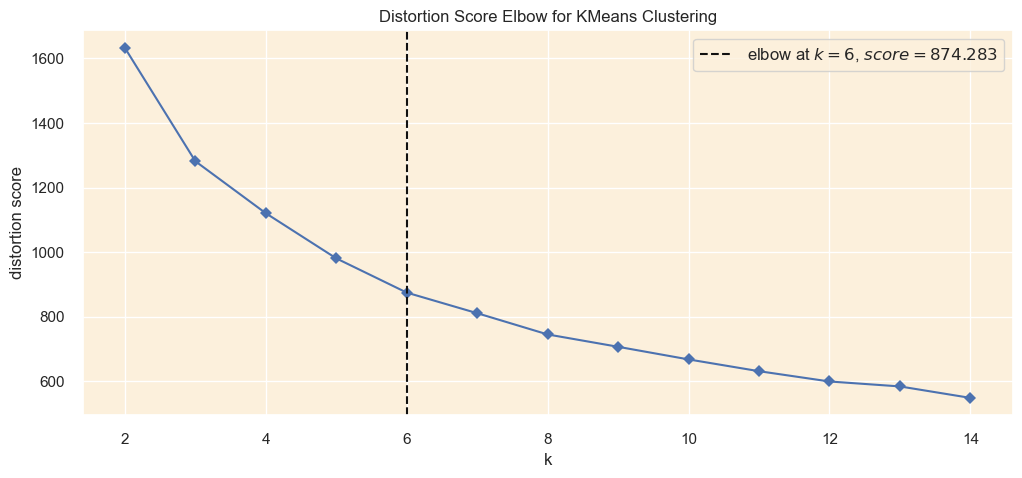

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=300, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

visualizer.show()

The elbow point represents the ideal value of k for the KMeans clustering algorithm. Using the YellowBrick library for the Elbow method, we find that the best k number is 6. However, there is no clear elbow point in this situation, which is common in real-world data. The plot shows that the inertia decreases dramatically up to k=6, indicating that the optimal value of k is between 3 and 7.

#### Silhouette Method
The Silhouette Method is a technique for determining the ideal number of clusters in a dataset by assessing consistency within clusters and their separation from other clusters.  It calculates the silhouette coefficient for each data point, which indicates how similar a point is to its own cluster against other clusters.

In [24]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(7, 0.215, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

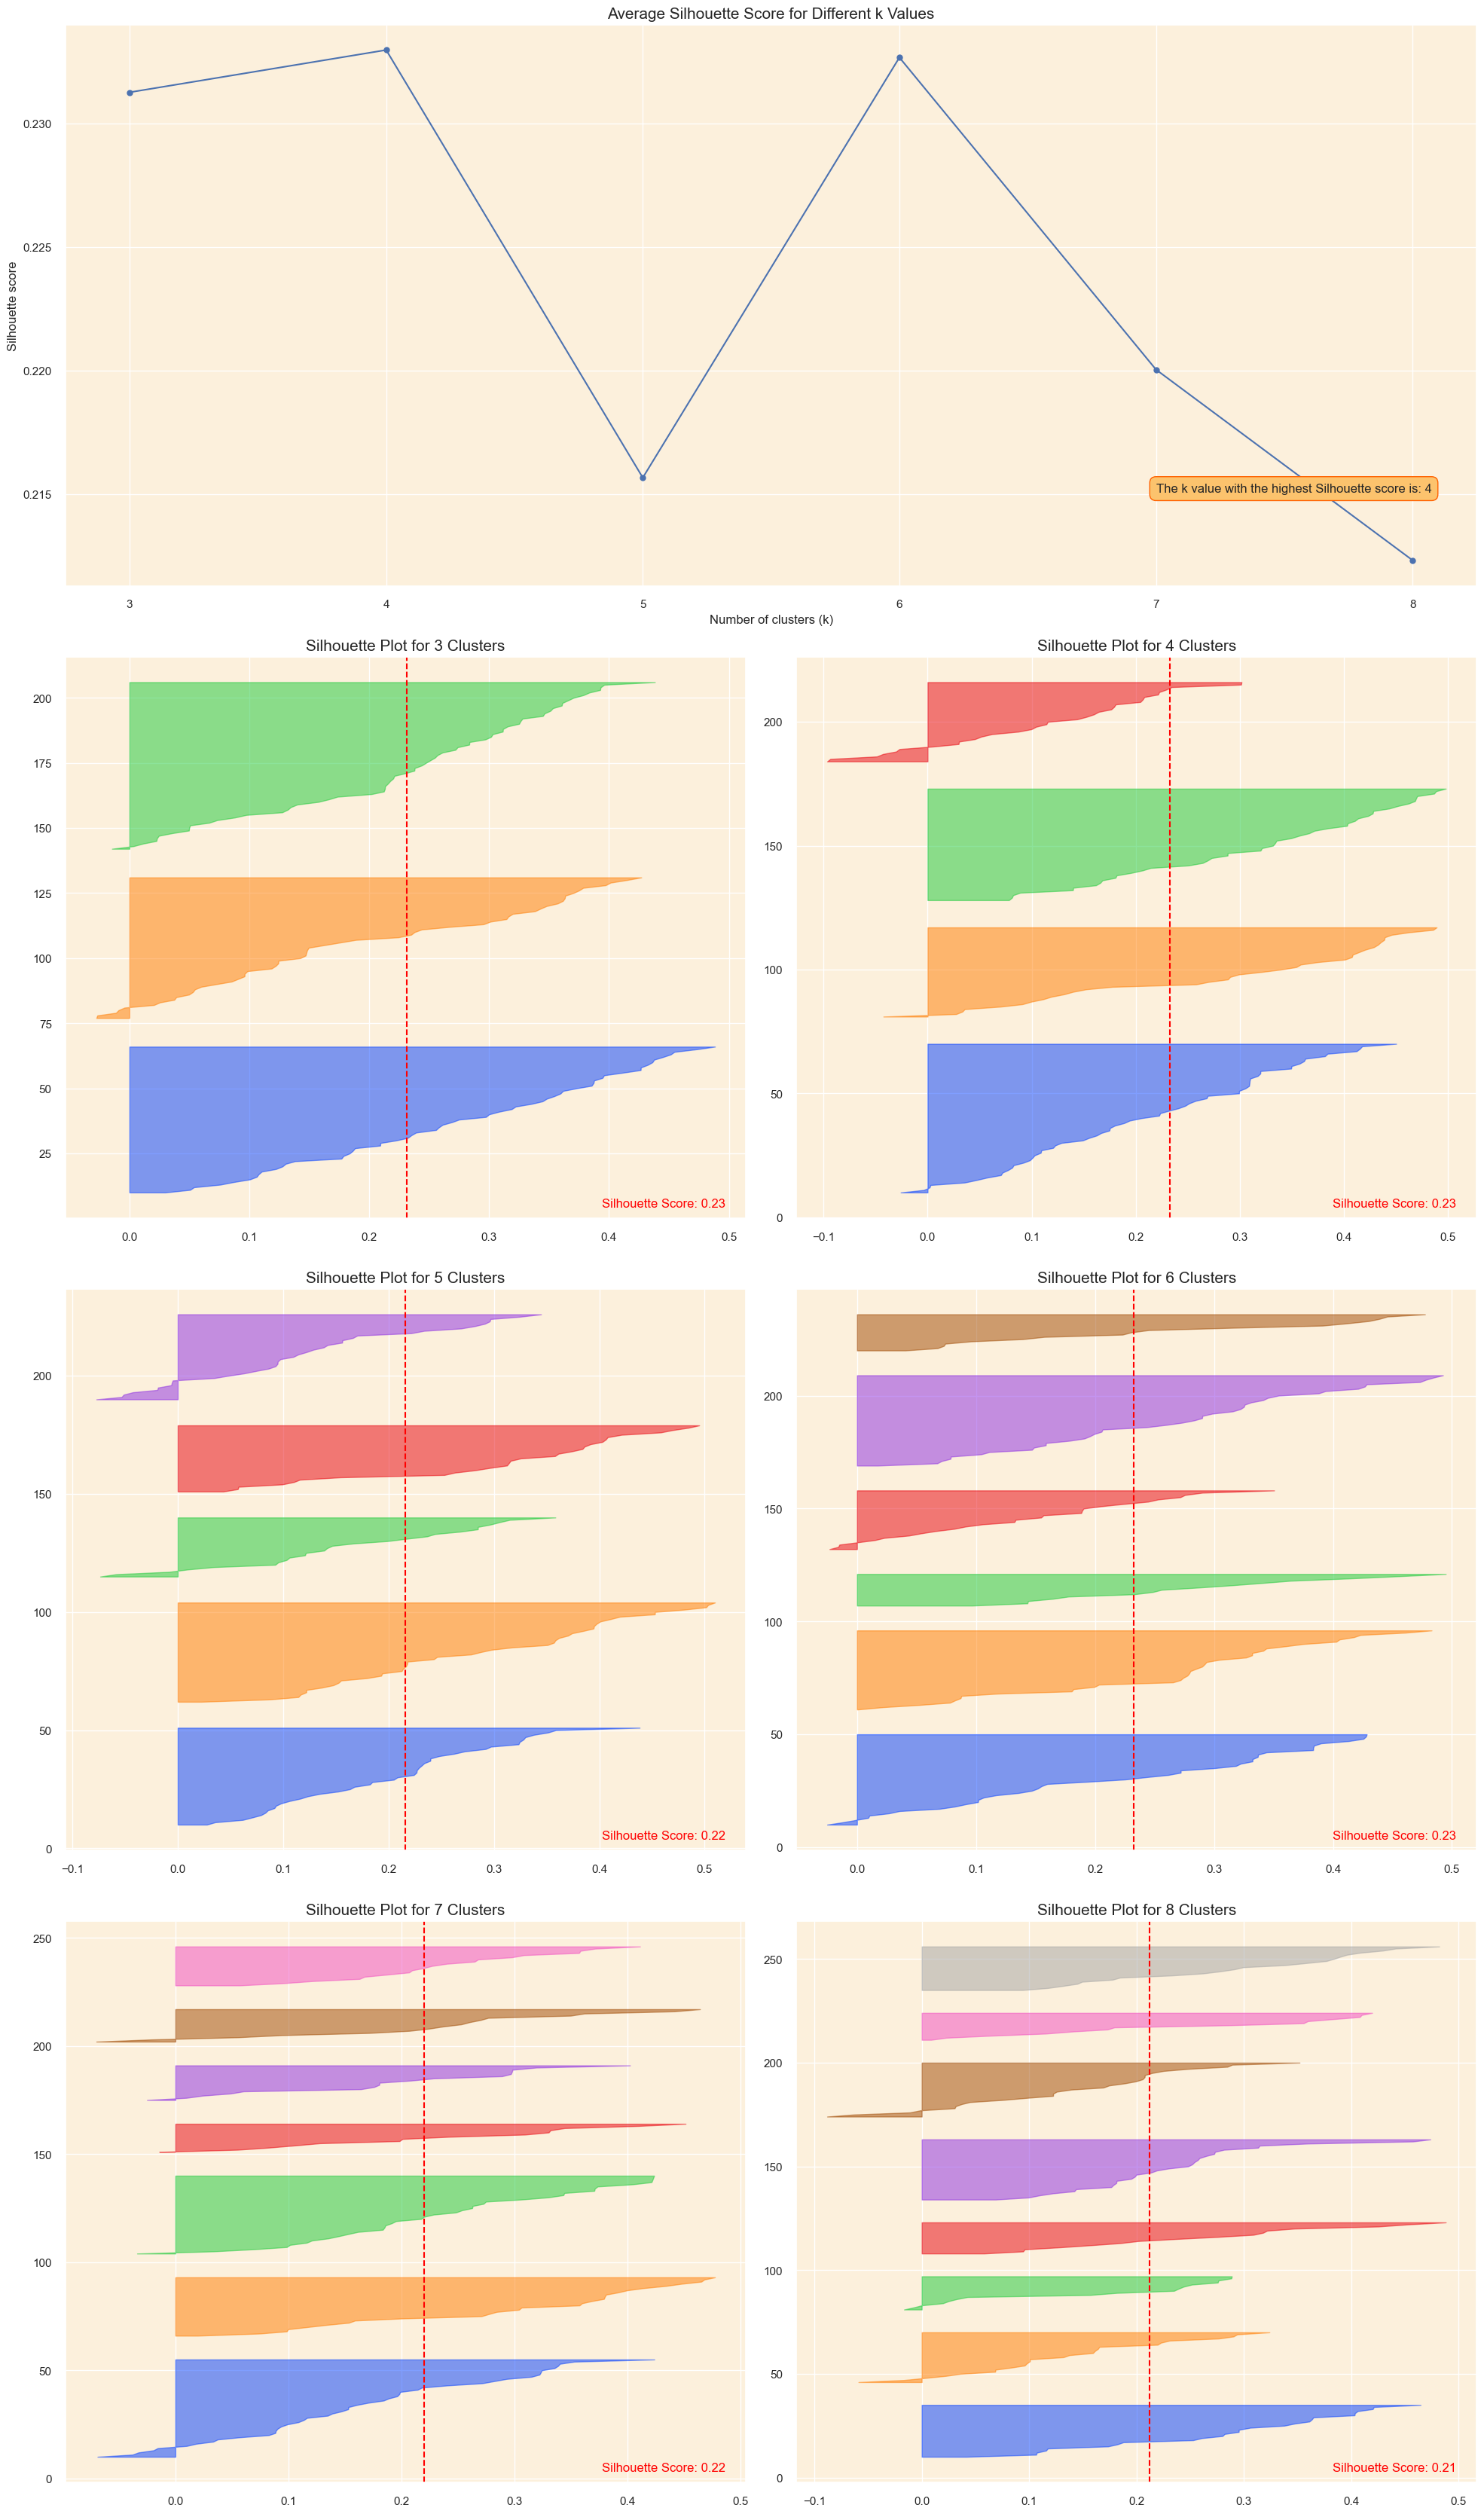

In [25]:
silhouette_analysis(customer_data_pca, 3, 8, figsize=(20, 50))

To choose the optimal number of clusters (k), I analyzed the silhouette plots by looking for clusters with wide silhouette widths (close to +1), indicating well-defined clusters. I sought a high average silhouette score, which suggests better separation between clusters. I also examined the uniformity in cluster sizes, preferring clusters with similar thicknesses to ensure a balanced structure. Clear peaks in the average silhouette score plot helped identify the optimal k, while avoiding fluctuations in silhouette widths, which would indicate poor cluster separation. Ultimately, I selected the k=3 value that maximized the overall average silhouette score, ensuring compact, well-separated clusters.

### Clustering Model - K-Means

In this step, I am going to apply the K-means clustering algorithm to segment customers into different clusters based on their profile and transaction history and other characteristics, using the optimal number of clusters determined in the previous step.

In [26]:
# apply K-means clustering
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(customer_data_pca)

# get frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

# reverse the mapping to assign labels
# label_mapping = {v:k for k, v in {2:1, 1:0, 0:2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [27]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Hemisphere_East,Hemisphere_West,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,C0001,56,5,12,3354.52,670.904,5,72.000000,1,3,0,1,670.904000,456.643861,217.032000,0
1,C0002,25,4,10,1862.74,465.685,4,48.000000,1,1,1,0,465.685000,219.519169,-147.630000,0
2,C0003,126,4,14,2725.38,681.345,4,27.333333,6,2,0,1,908.460000,685.907372,631.420000,2
3,C0004,5,8,23,5354.88,669.360,8,22.428571,0,10,0,1,764.982857,489.591411,70.506429,1
4,C0005,54,3,7,2034.24,678.080,3,91.500000,0,0,1,0,678.080000,310.820746,-270.990000,0


## Clustering Evaluation
After finding the appropriate number of clusters (three in our case) through elbow and silhouette analyses, I proceed to the evaluation process to analyze the quality of the clusters generated.  This stage is critical for validating the effectiveness of the clustering and ensuring that the clusters are coherent and well-separated.  The evaluation metrics and a visualization technique I want to employ are mentioned below.

- `3D Visualization of Top PCs`
- `Cluster Distribution Visualization`
- `Evaluation Metrics`
    - `Silhouette Score`
    - `Davies Bouldin Score`

###  3D Visualization of Top Principal Components

In [28]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

### Cluster Distribution Visualization

I am going to utilize a bar plot to visualize the percentage of customers in each cluster, which helps in understanding if the clusters are balanced and significant:

In [29]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

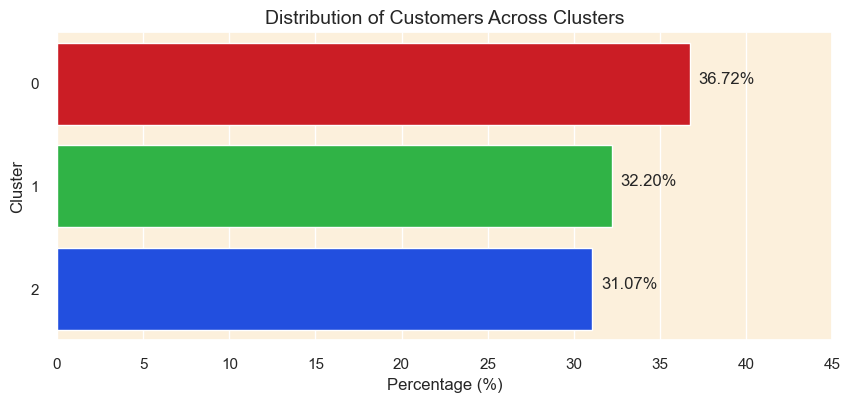

In [30]:
# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

Inference:
- The distribution of customers is highly balanced with clusters 1 and 2 holding almost equal customers at 32% and 31% approximately. Cluster 0 holds the most customers at approximately 37%.

- This balanced distribution implies that our clustering algorithm was mostly successful in discovering important patterns in the data, rather than simply grouping noise or outliers.  It suggests that each cluster represents a significant and separate portion of the client base, providing vital insights into future company plans.

- Furthermore, the fact that no cluster has a very small percentage of consumers ensures that each cluster is meaningful and not simply outliers or noise in the data.  This configuration enables a more detailed understanding and analysis of various client categories, supporting effective and informed decision-making.


### Evalutation Metrics 
To further ensure the quality of our clustering, I will employ the following metrics:

- `Silhouette Score`: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.

- `Davies Bouldin Score`: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [31]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+------------------------+--------------------+
|         Metric         |       Value        |
+------------------------+--------------------+
| Number of Observations |        177         |
|    Silhouette Score    | 0.2312516695336817 |
|  Davies Bouldin Score  | 1.3788282437950248 |
+------------------------+--------------------+


Clustering Quality Inference:
- The Silhouette Score of roughly 0.231, while not close to 1, indicates a reasonable level of separation between the clusters. It implies that the clusters are different, but there may be minor overlaps between them. A score closer to one would be desirable, suggesting more distinct and well-separated clusters.

- The Davies Blouding Score of 1.378 is a decent value that indicates a moderate level of similarity between each cluster and its counterpart. A lower score is generally preferable because it implies less similarity between clusters, and hence our score here reflects a good separation between the clusters.

Ultimately, the metrics indicate that the clustering is of good quality, with clusters that are well-defined and reasonably separated.  However, there may still be room for additional optimization to improve cluster separation and definition.

## Cluster Analysis and Profiling

In this section, I will analyze the features of each cluster to better understand the varied behaviors and preferences of various client groups, as well as profile each cluster to determine the important traits that define the customers in each cluster, by using the Radar Chart Approach.

In [32]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')
# df_customer

In [33]:
# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

In [34]:
# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

In [35]:
# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

In [36]:
# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)


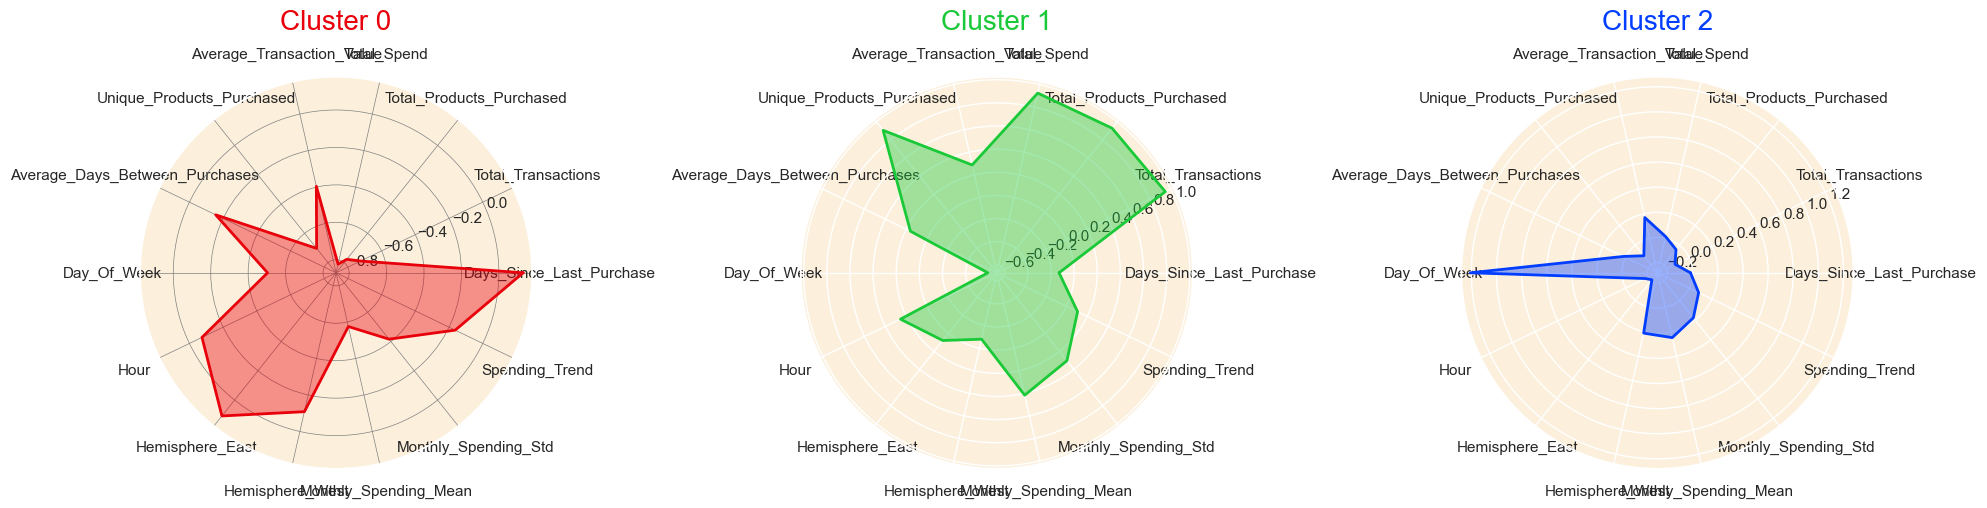

In [37]:
# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

### Customer Profiles Derived from Radar Chart Analysis

Cluster 0 (Red Chart)

**Profile:** Infrequent low spenders with a moderate spending trend

- Customers in this cluster show low levels of spending and very infrequent transactions, as indicated by low `Total_Spend` and high `Days_Since_Last_Purchase`.
- They exhibit a high spending trend, suggesting their spending is slowly increasing over time.
- These customers prefer shopping late in the day—as shown by the high `Hour` value—and mainly reside in the Eastern Hemisphere (with a few from the Western Hemisphere).
- Their average transaction value is moderate, implying that when they spend, the amount is not substantial.

Cluster 1 (Green Chart)

**Profile:** Frequent High-Spenders

- Customers in this cluster are high spenders with a very high `Total_Spend`, and they purchase a wide variety of unique products.
- They engage in frequent transactions, purchasing a high number of products.
- These customers tend to shop very early in the week (indicated by the low `Day_Of_Week`) and typically during the middle of the day.
- Their monthly spending shows comparatively high variability, suggesting less predictable spending patterns.
- Despite their high spending, they exhibit a low spending trend, implying that their spending levels might be decreasing over time.

Cluster 2 (Blue Chart)

**Profile:** Sporadic Shoppers with a Preference for Weekend Shopping

- Customers in this cluster tend to spend less overall, with fewer transactions and products purchased.
- They have a slight tendency to shop during the weekends, as indicated by the very high `Day_of_Week` value.
- Their spending trend is relatively stable but remains on the lower side, accompanied by low monthly spending variation.
- The average transaction value is lower, suggesting that when they do shop, they tend to spend less per transaction.
- Overall, they generally complete fewer transactions and purchase fewer products.